In [1]:
!unzip /content/drive/My\ Drive/BCI/train-bci.zip

Archive:  /content/drive/My Drive/BCI/train-bci.zip
   creating: train/
  inflating: train/subj10_series1_data.csv  
  inflating: train/subj10_series1_events.csv  
  inflating: train/subj10_series2_data.csv  
  inflating: train/subj10_series2_events.csv  
  inflating: train/subj10_series3_data.csv  
  inflating: train/subj10_series3_events.csv  
  inflating: train/subj10_series4_data.csv  
  inflating: train/subj10_series4_events.csv  
  inflating: train/subj10_series5_data.csv  
  inflating: train/subj10_series5_events.csv  
  inflating: train/subj10_series6_data.csv  
  inflating: train/subj10_series6_events.csv  
  inflating: train/subj10_series7_data.csv  
  inflating: train/subj10_series7_events.csv  
  inflating: train/subj10_series8_data.csv  
  inflating: train/subj10_series8_events.csv  
  inflating: train/subj11_series1_data.csv  
  inflating: train/subj11_series1_events.csv  
  inflating: train/subj11_series2_data.csv  
  inflating: train/subj11_series2_events.csv  
  inflat

In [2]:
!pip install scipy==1.2.1

     |████████████████████████████████| 24.8MB 1.4MB/s 
ERROR: umap-learn 0.4.2 has requirement scipy>=1.3.1, but you'll have scipy 1.2.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.2.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [0]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score as auc
from scipy.interpolate import spline

In [0]:
data=pd.read_csv('/content/train/subj1_series1_data.csv')
ev=pd.read_csv('/content/train/subj1_series1_events.csv')

In [5]:
data.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,158,543,-166,192,230,573,860,128,59,272,473,325,379,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,166,495,-138,201,233,554,846,185,47,269,455,307,368,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,177,534,-163,198,207,542,768,145,52,250,452,273,273,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,180,525,-310,212,221,542,808,115,41,276,432,258,241,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,165,507,-320,242,230,545,865,180,89,288,444,275,275,550,324,346,76,547,343,446,171,67,581


In [6]:
ev.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series1_0,0,0,0,0,0,0
1,subj1_series1_1,0,0,0,0,0,0
2,subj1_series1_2,0,0,0,0,0,0
3,subj1_series1_3,0,0,0,0,0,0
4,subj1_series1_4,0,0,0,0,0,0


In [0]:
class eegdata(Dataset):
  def __init__(self,path,validation=False,subjects=range(1,13)):
    super().__init__()
    data,self.target=self.readfiles(path,validation,subjects)
    self.mean=data.mean(axis=0)
    self.std=data.std(axis=0)
    self.data=self.norm(data)

  def norm(self,x):
    return ((x-self.mean)/self.std)

  def to_np(self,values):
    count=0
    for i in range(len(values)):
      count+=len(values[i])

    #create np array size all data
    ret=np.zeros((count,len(values[0][0])))

    #copy data to array
    ix=0
    for i in range(len(values)):
      ret[ix:ix+len(values[i]), :] = values[i]
      ix+=len(values[i])
    return ret

  def readfiles(self,path,validation,subjects):
    allx=[]
    ally=[]
    series=[1,2,3,4,5,6,7,8] if validation==False else [3]

    for i in subjects:
      print('log: reading subject {}'.format(i))
      xs=None
      ys=None

      for j in series:
        data='subj{}_series{}_data.csv'.format(i,j)
        events='subj{}_series{}_events.csv'.format(i,j)

        x=pd.read_csv(path+data).values[:,1:]
        xs=x if xs is None else np.vstack((xs,x))

        y=pd.read_csv(path+events).values[:,1:]
        ys = y if ys is None else np.vstack((ys, y))

      allx.append(xs)
      ally.append(ys)

    xs=self.to_np(allx)
    ys=self.to_np(ally)

    return xs,ys

  def __getitem__(self,index):
    return self.data[index],self.target[index]

  def __len__(self):
    return len(self.data)

In [10]:
# load subjects data into one big array using object created above
# if not enough RAM is available, only load some subjects at a time, and train on these subjects seperately
# i.e. train on subjects 1-5, then 5-9, then 9-12. Here the code starts off by loading up subjects 1-4 only.

subjects=range(9,12)
traindata=eegdata('/content/train/',subjects=subjects)
valdata=eegdata('/content/train/',subjects=subjects,validation=True)

log: reading subject 9
log: reading subject 10
log: reading subject 11
log: reading subject 9
log: reading subject 10
log: reading subject 11


In [14]:
def get_individuals(individuals=range(9,12)):
  #subjects=[]
  #vals=[]
  for i in individuals:
    s=[i]
    subject=eegdata('/content/train/',subjects=s)
    v=eegdata('/content/train/',validation=True,subjects=s)
    subjects.append(subject)
    vals.append(v)

  return subjects,vals
subjects,vals=get_individuals()

log: reading subject 9
log: reading subject 9
log: reading subject 10
log: reading subject 10
log: reading subject 11
log: reading subject 11


In [0]:
#see how eeg readings change over time
def get_spike(subject, event, average=True):
    spike=np.zeros([19,32])
    s=subject
    indexes=np.where(subjects[s].target[:,event] == 1)[0]
    i=0
    div=0
    while i < len(indexes):
        ix = subjects[s].data[indexes[i]-100:indexes[i+149]+50]
        spike+=ix[::16]
        div+=1
        i+=150
    spike/=div
    if average==True:
        spike = spike.mean(axis=1)
    return spike

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: Deprec

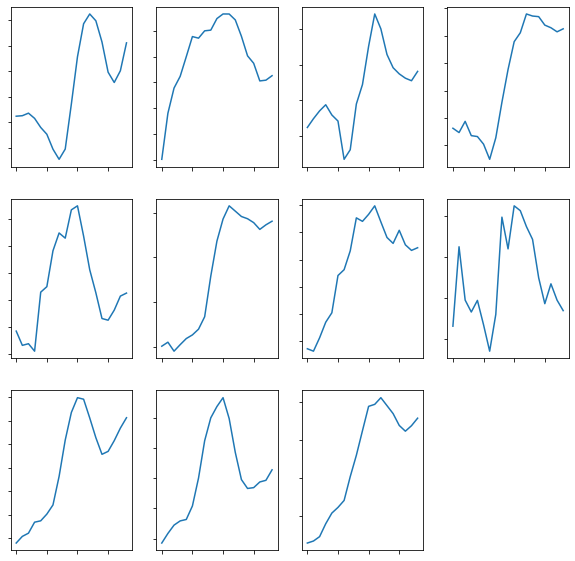

In [18]:
fig=plt.figure(12,figsize=[10,10])
for s in range(11):
  ax=fig.add_subplot(3,4,s+1)
  spike=get_spike(s,0)
  xnew=np.linspace(0,len(spike),19)

  smooth=spline(xnew,spike,xnew)
  ax.plot(range(len(spike)),spike)
  ax.set_xticklabels([])
  ax.set_yticklabels([])

In [17]:
print(len(subjects))

11


In [0]:
#params for the model
num_features=32
window_size=1024
batch_size=2000  

In [0]:
#Batch creator. When training it will return random locations in the dataset. The data is a time series 
#and so we feed previous readings (going back window_size) in with each index. Rather than feed in all window_size 
#previous readings, we subsample and take every 4th set of readings.

def get_batch(dataset,batch_size=2000,val=False,index=None):
  if val==False:
    index=random.randint(window_size,len(dataset)-16*batch_size)
    indexes=np.arange(index,index+16*batch_size,16)
  else:
    indexes=np.arange(index,index+batch_size)
  
  batch=np.zeros((batch_size,num_features,window_size//4))
  b=0
  for i in indexes:
    start=i-window_size if i-window_size>0 else 0
    tmp=dataset.data[start:i]
    batch[b,:,:]=tmp[::4].transpose()
    b+=1
  
  targets=dataset.target[indexes]
  return torch.DoubleTensor(batch),torch.DoubleTensor(targets)

In [0]:
class convmodel(nn.Module):
  def __init__(self,out_classes,drop=0.5,d_linear=124):
    super().__init__()

    self.conv2=nn.Conv1d(32,64,kernel_size=3,padding=0,stride=1)
    self.bn=nn.BatchNorm1d(64)
    self.pool=nn.MaxPool1d(2,stride=2)
    self.linear1=nn.Linear(8128,d_linear)

    self.linear3=nn.Linear(d_linear,out_classes)
    self.dropout1=nn.Dropout(drop)
    self.dropout2=nn.Dropout(drop)
    self.dropout3=nn.Dropout(drop)

    self.conv=nn.Sequential(self.conv2,nn.ReLU(inplace=True),self.bn,self.pool,self.dropout1)
    self.dense=nn.Sequential(self.linear1,nn.ReLU(inplace=True),self.dropout2,self.dropout3,self.linear3)

  def forward(self,x):
    bs=x.size(0)
    x=self.conv(x)
    x=x.view(bs,-1)
    output=self.dense(x)

    return torch.sigmoid(output)

In [0]:
model=convmodel(6).double()
optim=torch.optim.Adadelta(model.parameters(),lr=1,eps=1e-10)

In [23]:
#train the model
bs=batch_size

def train(traindata,epochs,printevery=100,shuffle=True):
  model.train()
  for epoch in range(epochs):
    total_loss=0
    for i in range(len(traindata)//bs):
      optim.zero_grad()
      x,y=get_batch(traindata)
      preds=model(x)
      loss=F.binary_cross_entropy(preds.view(-1),y.view(-1))
      loss.backward()
      total_loss+=loss.item()
      optim.step()
      if (i+1)%printevery==0:
        print("epoch: %d, iter %d/%d, loss %.4f"%(epoch + 1, i + 1, len(traindata)//2000, total_loss/printevery))
        total_loss=0

#train for 1 epoch
train(traindata,1)

epoch: 1, iter 100/2227, loss 0.4960
epoch: 1, iter 200/2227, loss 0.2773
epoch: 1, iter 300/2227, loss 0.2077
epoch: 1, iter 400/2227, loss 0.1787
epoch: 1, iter 500/2227, loss 0.1708
epoch: 1, iter 600/2227, loss 0.1549
epoch: 1, iter 700/2227, loss 0.1441
epoch: 1, iter 800/2227, loss 0.1412
epoch: 1, iter 900/2227, loss 0.1361
epoch: 1, iter 1000/2227, loss 0.1379
epoch: 1, iter 1100/2227, loss 0.1288
epoch: 1, iter 1200/2227, loss 0.1160
epoch: 1, iter 1300/2227, loss 0.1160
epoch: 1, iter 1400/2227, loss 0.1159
epoch: 1, iter 1500/2227, loss 0.1134
epoch: 1, iter 1600/2227, loss 0.1164
epoch: 1, iter 1700/2227, loss 0.1119
epoch: 1, iter 1800/2227, loss 0.1148
epoch: 1, iter 1900/2227, loss 0.1026
epoch: 1, iter 2000/2227, loss 0.1084
epoch: 1, iter 2100/2227, loss 0.1067
epoch: 1, iter 2200/2227, loss 0.1068


In [0]:
!mkdir models

In [0]:
torch.save(model.state_dict(), "/content/models/Convnet_epoch1")

In [0]:
a=model.load_state_dict(torch.load("/content/models/Convnet_epoch1"))

In [0]:
def getPredictions(data):
    
    model.eval()
    p=[]
    res=[]
    i=window_size
    bs=2000
    while i<len(data):
        if i+bs > len(data):
            bs=len(data) - i
             
        x,y=get_batch(data,bs,index=i,val=True)
        preds=model(x)
        preds=preds.squeeze(1)
        p.append(np.array(preds.cpu().data))
        res.append(np.array(y.data))

        i+=bs
    
    preds=p[0]
    for i in p[1:]:
        preds=np.vstack((preds,i))
    
    targs=res[0]
    for i in res[1:]:
        targs=np.vstack((targs, i))
    return preds, targs

def valscore(preds, targs):
    aucs=[auc(targs[:, j],preds[:, j]) for j in range(6)]
    total_loss=np.mean(aucs)
    print(total_loss)

In [28]:
preds, targs = getPredictions(valdata)
valscore(preds, targs)

0.8357429244716003


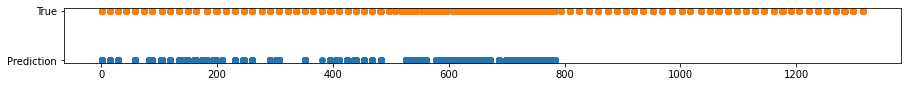

In [29]:
#visualizing the prediction
def show_whole_series(f=1, th=0.3):

    ps = np.where(preds[:,f] > th)
    true = np.where(targs[:,f] == 1)
    fig = plt.figure(figsize=[15,1])
    ax1 = fig.add_subplot(1,1,1)
    ax1.scatter(ps[0]/500, ['Prediction']*len(ps[0]))
    ax1.scatter(true[0]/500, ['True']*len(true[0]))

show_whole_series()

In [0]:
#training on specific individuals
def train_individuals(subjects, vals):
    for i in range(12):
        model.load_state_dict(torch.load("/content/models/Convnet_epoch1"))
        train(subjects[i], 1)
        print('')
        valscore(vals[i])
        torch.save(model.state_dict(), "/content/models/subj_{}_epoch2".format(i + 1))

train_individuals(subjects,vals)
#too much consumption of RAM